In [1]:
import os
from transformers import DetrImageProcessor, DetrForObjectDetection
import cv2
import shutil
from helper import *
import numpy as np
import torch
from scipy import spatial
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
bd_configPath = 'models/bib_detector/RBNR2_custom-yolov4-tiny-detector.cfg'
bd_weightsPath = 'models/bib_detector/RBNR2_custom-yolov4-tiny-detector_best.weights'
bd_classes = ['bib']
bd = BibDetector(bd_configPath, bd_weightsPath, bd_classes)

human_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
human_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

extract_dir = "/Users/arpitsharma/Downloads/Extract"
organize_dir = "/Users/arpitsharma/Downloads/organized_photos"

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [3]:
path_to_file = "/Users/arpitsharma/Downloads/TBT/TBT-468.jpg"

img = cv2.cvtColor(cv2.imread(path_to_file), cv2.COLOR_BGR2RGB)

runner = Runner(filename=path_to_file)

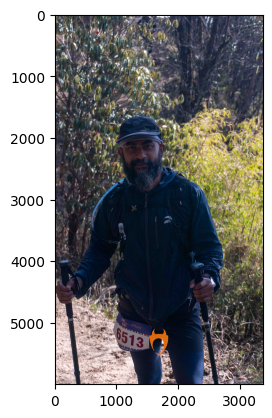

In [4]:
plt.imshow(img)

In [5]:
inputs = human_processor(images=img, return_tensors="pt")
outputs = human_model(**inputs)

In [6]:
target_sizes = torch.tensor([img.shape[:2]])
results = human_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

In [7]:
results

{'scores': tensor([0.9712, 0.9997], grad_fn=<IndexBackward0>),
 'labels': tensor([39,  1]),
 'boxes': tensor([[2226.2222, 4076.6211, 2672.5508, 5979.3359],
         [  12.9961, 1642.9291, 2748.9802, 5921.8677]],
        grad_fn=<IndexBackward0>)}

In [10]:
score, label, box = results["scores"], results["labels"], results["boxes"]

i = 1

if human_model.config.id2label[label[i].item()] == "person":
    hbox = [int(i) for i in box[i].tolist()]
    runner.body_location = hbox
    runner.embeddings(img)
    body = img[hbox[1]:hbox[3], hbox[0]:hbox[2]]
else:
    print(False)

1/1 [==============================] - 1s 559ms/step


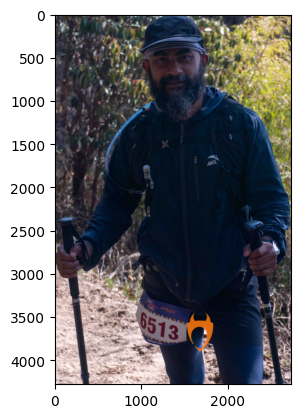

In [11]:
plt.imshow(body)

In [16]:
bib_detections_probables = bd.detect(img, 0.25, swapRB=True) + bd.detect(img, 0.25, swapRB=False)

In [13]:
bib_detections_probables = bd.de_duplicate(bib_detections_probables)

bib_detections = []
body_box = runner.body_location

for bib_box in bib_detections_probables:
    (x, y, w, h) = bib_box
    
    x = x + body_box[0]
    y = y + body_box[1]
    
    if x >= body_box[0] and y >= body_box[1] and x + w <= body_box[2] and y + h <= body_box[3]:
        bib_detections.append([x, y, w, h])

In [17]:
bib_detections_probables

[]

In [19]:
for bib_box in bib_detections:
    (x1, y1, x2, y2) = convert_opencv_to_dlib(bib_box)
    runner.bib_location = (x1, y1, x2, y2)
    
    bib_number = bd.process_image(img[y1:y2, x1:x2])

/Users/arpitsharma/miniconda3/envs/vision/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


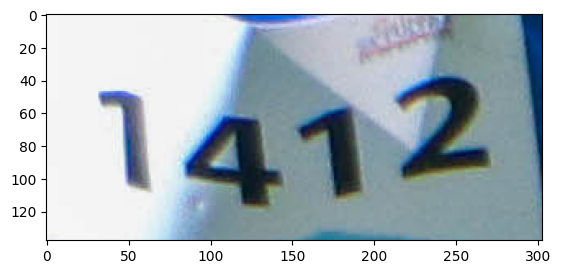

In [20]:
plt.imshow(img[y1:y2, x1:x2])

In [18]:
bib_number = bd.process_image(img)
print(bib_number)

/Users/arpitsharma/miniconda3/envs/vision/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


F


In [23]:
runner.bib_number = bib_number

In [6]:
import csv

participants = open("participants.csv", mode='w')
nonparticipants = open("non_participants.csv", mode='w')

fields = ["filename","body_x1", "body_y1", "body_x2", "body_y2", "face_x1", "face_y1", "face_x2", "face_y2", 
          "bib_x1", "bib_y1", "bib_x2", "bib_y2", "bib_number"]

runnerwriter = csv.DictWriter(participants, fieldnames=fields)
runnerwriter.writeheader()

nonrunnerwriter = csv.DictWriter(nonparticipants, fieldnames=fields)
nonrunnerwriter.writeheader()

embeddings_identified = open("embeddings_identified.csv", mode='w')
identifiedwriter = csv.writer(embeddings_identified)

embeddings_unidentified = open("embeddings_unidentified.csv", mode='w')
unidentifiedwriter = csv.writer(embeddings_unidentified)

photos_dir = "/Users/arpitsharma/Downloads/hell_race"

for i, filename in enumerate(os.listdir(photos_dir)):

    filenumber = i + 1
    human = 0
    full_image = False
    bib = 0

    img = cv2.cvtColor(cv2.imread(os.path.join(photos_dir, filename)), cv2.COLOR_BGR2RGB)

    inputs = human_processor(images=img, return_tensors="pt")
    outputs = human_model(**inputs)

    target_sizes = torch.tensor([img.shape[:2]])
    results = human_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)

    bib_detections_probables = bd.detect(img, 0.20, swapRB=True) + bd.detect(img, 0.20, swapRB=False)
    bib_detections_probables = bd.de_duplicate(bib_detections_probables)
    print(filename, bib_detections_probables)

    for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):

        if human_model.config.id2label[label.item()] == "person" and round(score.item(), 3) > 0.9:
            body_box = [int(i) for i in box.tolist()]
            human += 1

            runner = Runner(filename=filename)
            runner.body_location = body_box                                                                      # Save the body box of the runner
            runner.embeddings(img)                                                                                  # Calculate the embedding vector for the detected faces

            bib_detections = []

            for bib_box in bib_detections_probables:
                (x, y, w, h) = bib_box

                if x >= body_box[0] and y >= body_box[1] and x + w <= body_box[2] and y + h <= body_box[3]:
                    bib_detections.append((x, y, w, h))

            if len(bib_detections) == 0:
                body = img[body_box[1]:body_box[3], body_box[0]:body_box[2]]
                bib_detections = bd.detect(body, 0.2, swapRB=True, offset=body_box) + bd.detect(body, 0.2,
                                                                                                swapRB=False,
                                                                                                offset=body_box)
                bib_detections = bd.de_duplicate(bib_detections)

                print(filename, bib_detections)

            if len(bib_detections):

                for bib_box in bib_detections:
                    (x1, y1, x2, y2) = convert_opencv_to_dlib(bib_box)
                    runner.bib_location = (x1, y1, x2, y2)

                    bib_number = bd.process_image(img[y1:y2, x1:x2])

                    if is_correct(bib_number, event="TBTT"):
                        bib += 1
                        runner.bib_number = bib_number
                        runner.identified = True
                        print("Found bib number:", bib_number)

                        runner.save(runnerwriter)
                        if runner.face_vectors is not None:
                            identifiedwriter.writerow(list(runner.face_vectors[0]))
                        else:
                            identifiedwriter.writerow(list(np.zeros(shape=(512,))))
                        
                    else:

                        if runner.identified and not runner.bib_number:
                            runner.save(nonrunnerwriter)
                            if runner.face_vectors is not None:
                                unidentifiedwriter.writerow(list(runner.face_vectors[0]))
                            else:
                                unidentifiedwriter.writerow(list(np.zeros(shape=(512,))))
                        
                        print(f"[ERROR] {filenumber} {filename} invalid bib number range:", bib_number)

            else:

                if runner.identified and not runner.bib_number:
                    runner.save(nonrunnerwriter)
                    if runner.face_vectors is not None:
                        unidentifiedwriter.writerow(list(runner.face_vectors[0]))
                    else:
                        unidentifiedwriter.writerow(list(np.zeros(shape=(512,))))
                
                print(f"[ERROR] {filenumber} {filename} no bib detected.")
                continue

    if human == 0 or bib == 0:
        err = f"[ERROR] {filenumber} {filename} no human or bib detected. humans: {human} & bibs: {bib}"
        print(err)

participants.close()
nonparticipants.close()
embeddings_identified.close()
embeddings_unidentified.close()

Copy of SSU22-2101.jpg [[1843, 4104, 409, 287]]
1/1 [==============================] - 1s 533ms/step


/Users/arpitsharma/miniconda3/envs/vision/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Found bib number: 3065
40161775_1429457957185386_5440678869071822848_o.jpg [[390, 1555, 345, 140]]
1/1 [==============================] - 0s 30ms/step
Found bib number: 1298
Copy of SSU22-1640.jpg [[219, 2752, 269, 219]]
1/1 [==============================] - 0s 28ms/step
Found bib number: 1424
1/1 [==============================] - 0s 29ms/step
Copy of SSU22-1640.jpg []
[ERROR] 3 Copy of SSU22-1640.jpg no bib detected.
Copy of SSU22-1691.jpg []
1/1 [==============================] - 0s 11ms/step
Copy of SSU22-1691.jpg [[2736, 2003, 303, 138]]
Found bib number: 1412
Copy of SSU22-1692.jpg [[1639, 3302, 641, 340]]
1/1 [==============================] - 0s 34ms/step
Found bib number: 1412
Copy of SSU22-1489.jpg [[1783, 2181, 549, 286]]
1/1 [==============================] - 0s 31ms/step
Found bib number: 3065
DSC_0475.jpg [[685, 2872, 504, 257], [2251, 3238, 548, 213], [3461, 3224, 492, 234]]
1/1 [==============================] - 0s 30ms/step
DSC_0475.jpg []
[ERROR] 7 DSC_0475.jpg no bi

1/1 [==============================] - 0s 32ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
1/1 [==============================] - 0s 9ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
1/1 [==============================] - 0s 29ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
1/1 [==============================] - 0s 33ms/step
Found bib number: 3065
1/1 [==============================] - 0s 31ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
1/1 [==============================] - 0s 31ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
1/1 [==============================] - 0s 30ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
40159996_1429458533851995_8739191607548444672_o.jpg [[443, 1433, 276, 152]]
1/1 [==============================] - 0s 30ms/step
Found bib number: 1298
_

AttributeError: '_csv.writer' object has no attribute 'close'

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_runner = pd.read_csv("participants.csv", header=0)
df_non_runner = pd.read_csv("non_participants.csv", header=0)

In [3]:
emb_runner = pd.read_csv("embeddings_identified.csv", header=None)
emb_non_runner = pd.read_csv("embeddings_unidentified.csv", header=None)

In [4]:
start_index = df_runner.columns.get_loc('bib_number')
identified = pd.concat([df_runner.iloc[:, start_index], emb_runner], axis=1).reindex(df_runner.index)


In [5]:
start_index = df_runner.columns.get_loc('filename')
unidentified = pd.concat([df_non_runner.iloc[:, start_index], emb_non_runner], axis=1).reindex(df_non_runner.index)


In [6]:
identified = identified.loc[~(emb_runner==0).all(axis=1)]

In [7]:
mean_emb = np.array(identified.groupby(by='bib_number', sort=False).mean())
emb = np.array(emb_non_runner)

In [8]:
row_norms = np.linalg.norm(mean_emb, axis=1, keepdims=True)
mean_emb = mean_emb / row_norms

row_norms = np.linalg.norm(emb, axis=1, keepdims=True)
emb = emb / row_norms

In [9]:
result = 1 - np.dot(mean_emb, emb.T)
idx = list(np.argmin(result, axis=0))

In [10]:
indexs = list(identified.groupby(by='bib_number', sort=False).mean().index)

In [11]:
files_identified = []

In [12]:
import os, shutil
def copy_photos(src_path, dest_path, filename):
    
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
        
    try:
        shutil.copy(os.path.join(src_path, filename), os.path.join(dest_path, filename))
    except Exception as err:
        if filename == "TBT":
            filename = f"{filename} {line.split(' ')[3]}"
            shutil.copy(os.path.join(src_path, filename), os.path.join(dest_path, filename))
    except Exception as err:
        print(err)

In [17]:
dest_path = "/Users/arpitsharma/Downloads/TBT_Photos/"
src_path = "/Users/arpitsharma/Downloads/TBT/"

count = 0
for j, i in enumerate(idx):

    if result[i][j] < 0.3:
        count += 1

        filename = df_non_runner['filename'][j]
        closest_bib = indexs[i]
        
        files_identified.append(filename)
#         copy_photos(src_path, os.path.join(dest_path, str(closest_bib)), filename)

print("Files identified through Face:", count)

Files identified through Face: 691


In [18]:
df = pd.read_csv("results.csv", header=[0])
filtered_photos = df[df['error'].isnull()]

count = 0
for index, row in filtered_photos.iterrows():
    
    count += 1
    files_identified.append(row['filename'])
#     copy_photos(src_path, os.path.join(dest_path, str(int(row['bib_number']))), row['filename'])
        
print("Files identified through Bib:", count)

Files identified through Bib: 771


In [19]:
files_identified = list(set(files_identified))

In [20]:
dest_path = "/Users/arpitsharma/Downloads/TBT_ERROR/"
files = os.listdir(src_path)

for file in files:
    
    if file not in files_identified:
        copy_photos(src_path, os.path.join(dest_path), file)

In [15]:
len(os.listdir(src_path))

1533